In [2]:
import numpy as np
import sklearn.preprocessing
import time
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from torch.autograd import Variable

# import jtplot
from jupyterthemes import jtplot

# you can select an alternative theme's plot style by name
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('onedork')

# set "context" (paper, notebook, talk, or poster)
# & font scale (scalar applied to labels, legend, etc.)
jtplot.style('grade3', context='paper', fscale=1.4)

# turn on X- and Y-axis tick marks (default=False)
# and turn off the axis grid lines (default=True)
jtplot.style(ticks=True, grid=False)

# set the default figure size
# x (length), y (height)
jtplot.figsize(x=6., y=5.)

# or just adjust the aspect ratio
# new_length = length * aspect
jtplot.figsize(aspect=1.2)

### Data Preprocessing

In [3]:
data = np.loadtxt('CASP.csv', delimiter = ',', skiprows = 1)

X = data[:, 1:]
y = data[:,0]

X_train = X[:int(len(X)*0.9), :]
X_test = X[int(len(X)*0.9):, :]
y_train = y[:int(len(y)*0.9)]
y_test = y[int(len(y)*0.9):]

normalizer = sklearn.preprocessing.StandardScaler(copy = True, with_mean = True, with_std = True)
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

X_train = np.concatenate([np.ones(len(X_train)).reshape(len(X_train), 1), X_train], axis = 1)
X_test = np.concatenate([np.ones(len(X_test)).reshape(len(X_test), 1), X_test], axis = 1)

### Problem 4

In [4]:
# function that returns ridge regression weights
# takes as input: normalized X matrix with column of ones (X_train), vector of targets (y_train), and regularization parameter > 0 (reg_param)
# fitting procedure uses QR decomposition (see section 7.5.2 in Murphy text; in equation 7.43, Q should be Q^T)
def ridge_weights(X_train, y_train, reg_param):
    
    reg_param_matrix = np.zeros((X_train.shape[1], X_train.shape[1]))
    np.fill_diagonal(reg_param_matrix, np.sqrt(reg_param))

    X_train_tilde = np.concatenate([X_train, reg_param_matrix], axis = 0)
    y_train_tilde = np.concatenate([y_train, np.zeros(X_train.shape[1])], axis = 0)

    qr = np.linalg.qr(X_train_tilde, mode = 'reduced')

    return np.dot(np.dot(np.linalg.inv(qr[1]), qr[0].transpose()), y_train_tilde)

# function to calculate rmse
def rmse(X, Y, w):
    return np.sqrt(np.sum(np.square(np.dot(X, w) - Y))/len(Y))
    

# computing the regularization parameter to use in ridge_weights function
sigma2 = 1.0
tau2 = 0.1
my_lambda = sigma2/tau2

# getting ridge regression weights for CASP training data 
w_map = ridge_weights(X_train, y_train, my_lambda)

# computing rmse and printing w_map and rmse
print('w_map with QR = ' + str(w_map))
print()
print('Normalized test set RMSE with QR = ' + str(rmse(X_test, y_test, w_map)))

w_map with QR = [ 7.74153395  5.55782079  2.25190765  1.07880135 -5.91177796 -1.73480336
 -1.63875478 -0.26610556  0.81781409 -0.65913397]

Normalized test set RMSE with QR = 5.20880460745


### Problem 5

In [5]:
# initializing weights setting optimizer to use L-BFGS
weights = Variable(Tensor(np.zeros(10)), requires_grad = True)
optimizer = torch.optim.LBFGS([weights])

# function to calculate negative log posterior
def neg_log_posterior(X, Y, sigma2, tau2, w):
    return ((Y - X.dot(w)).T.dot(Y - X.dot(w)))/(2*sigma2) + (w.T.dot(w))/(2*tau2)

# function to compute gradient of negative log posterior with respect to w
def grad_neg_log_posterior_wrt_w(X, Y, sigma2, tau2, w):
    return -(X.T.dot(Y - X.dot(w)))/sigma2 + w/tau2

# function used to optimize in stepwise fashion
def black_box_1():
    weights_data = weights.data.numpy()
    weights.grad = Variable(Tensor(grad_neg_log_posterior_wrt_w(X_train, y_train, sigma2, tau2, weights_data)))
    return neg_log_posterior(X_train, y_train, sigma2, tau2, weights_data)

# running optimizer for 100 iterations
for i in range(100):
    optimizer.step(black_box_1)

# computing rmse and printing w_map and rmse
print('w_map with L-BFGS = ' + str(weights.data.numpy()))
print()
print('Normalized test set RMSE with L-BFGS = ' + str(rmse(X_test, y_test, weights.data.numpy())))

w_map with L-BFGS = [ 7.74153376  5.55782127  2.25190735  1.07880151 -5.91177797 -1.73480356
 -1.63875508 -0.2661055   0.81781411 -0.65913397]

Normalized test set RMSE with L-BFGS = 5.20880461163


### Problem 6

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


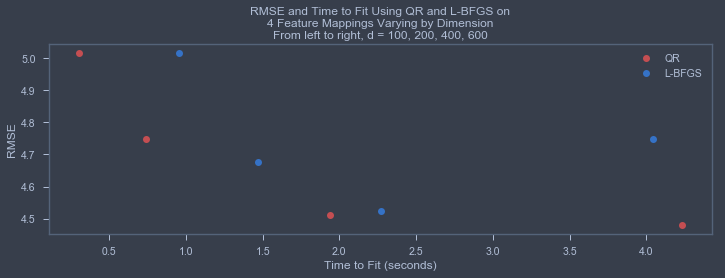

Test RMSE using QR when d = 100: 5.01647322197
Test RMSE using QR when d = 200: 4.74796602188
Test RMSE using QR when d = 400: 4.5127248348
Test RMSE using QR when d = 600: 4.48042136248
Test RMSE using L-BFGS when d = 100: 5.01656834273
Test RMSE using L-BFGS when d = 200: 4.74796605448
Test RMSE using L-BFGS when d = 400: 4.5255579894
Test RMSE using L-BFGS when d = 600: 4.67708251057


In [20]:
np.random.seed(10000)
# function to map original features into d-dimensional space with cos(A^Tx + b) where each column in A is MVN and b is a vector of uniform rvs
def mapping(X_train, X_test, num_functions):
    AT = np.random.multivariate_normal(np.zeros(X_train.shape[1]-1), np.identity(X_train.shape[1]-1), size = (num_functions)).T
    Xtrain_AT = X_train[:, 1:].dot(AT)
    Xtest_AT = X_test[:, 1:].dot(AT)
    unif = np.random.uniform(0, 2*np.pi, size = (num_functions))
    Xtrain_AT = np.add(Xtrain_AT, unif)
    Xtest_AT = np.add(Xtest_AT, unif)
    
    # adding column of ones for bias parameter
    Xtrain_AT_cos_ones = np.concatenate([np.ones(len(Xtrain_AT)).reshape(len(Xtrain_AT), 1), np.cos(Xtrain_AT)], axis = 1)
    Xtest_AT_cos_ones = np.concatenate([np.ones(len(Xtest_AT)).reshape(len(Xtest_AT), 1), np.cos(Xtest_AT)], axis = 1)

    return (Xtrain_AT_cos_ones, Xtest_AT_cos_ones)

# function used to optimize in stepwise fashion
def black_box_2():
    weights_data = weights.data.numpy()
    weights.grad = Variable(Tensor(grad_neg_log_posterior_wrt_w(mapped_features[0], y_train, sigma2, tau2, weights_data)))
    return neg_log_posterior(mapped_features[0], y_train, sigma2, tau2, weights_data)


rmse_QR_list = []
rmse_LBFGS_list = []
time_QR_list = []
time_LBFGS_list = []
for i in [100, 200, 400, 600]:
    # mapping features into i-dimensional space
    mapped_features = mapping(X_train, X_test, i)
    
    for j in [0, 1]:
        
        # using QR
        if j == 0:
            # timing how long QR takes to fit to transformed feature set
            time1 = time.time()
            w_map_mapped_features = ridge_weights(mapped_features[0], y_train, my_lambda)
            time2 = time.time()
            
            time_QR_list.append(time2 - time1)
            rmse_mapped_features = rmse(mapped_features[1], y_test, w_map_mapped_features) # computing rmse of model test set
            rmse_QR_list.append(rmse_mapped_features)
        
        # using L-BFGS
        elif j == 1:
            weights = Variable(Tensor(np.zeros(i + 1)), requires_grad = True)
            # playing with optimization parameters here
            optimizer = torch.optim.LBFGS([weights], lr = 0.3, max_iter = 10000000000000, tolerance_grad = 10**(-5), tolerance_change = 10**(-9)) 
            
            # timing how long L-BFGS takes to fit to transformed feature set
            time3 = time.time()
            optimizer.step(black_box_2)
            time4 = time.time()
            
            time_LBFGS_list.append(time4 - time3)
            rmse_mapped_features = rmse(mapped_features[1], y_test, weights.data.numpy()) # computing rmse of model test set
            rmse_LBFGS_list.append(rmse_mapped_features)
            
# plotting rmse vs. time to fit for each (d, method) pair           
plt.plot(time_QR_list, rmse_QR_list, 'ro')
plt.plot(time_LBFGS_list, rmse_LBFGS_list, 'bo')
plt.xlabel('Time to Fit (seconds)')
plt.ylabel('RMSE')
plt.title('RMSE and Time to Fit Using QR and L-BFGS on\n4 Feature Mappings Varying by Dimension\nFrom left to right, d = 100, 200, 400, 600')
plt.legend(['QR', 'L-BFGS'])
plt.show()

# printing rmse results for each (d, method) pair
print('Test RMSE using QR when d = 100: ' + str(rmse_QR_list[0]))
print('Test RMSE using QR when d = 200: ' + str(rmse_QR_list[1]))
print('Test RMSE using QR when d = 400: ' + str(rmse_QR_list[2]))
print('Test RMSE using QR when d = 600: ' + str(rmse_QR_list[3]))
print('Test RMSE using L-BFGS when d = 100: ' + str(rmse_LBFGS_list[0]))
print('Test RMSE using L-BFGS when d = 200: ' + str(rmse_LBFGS_list[1]))
print('Test RMSE using L-BFGS when d = 400: ' + str(rmse_LBFGS_list[2]))
print('Test RMSE using L-BFGS when d = 600: ' + str(rmse_LBFGS_list[3]))